In [16]:
from collections import defaultdict
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm


In [3]:
%config InlineBackend.figure_format='retina'


# Distance vs Energy plots

In [14]:
exp_dir_name_mapper = {
    'MoS2-plain-cv': 'MEGNet',
    'MoS2-plain-cv-catboost': 'Catboost+Matminer',
    'MoS2-plain-cv-gemnet': 'GemNet',
    'MoS2-plain-cv-schnet': 'SchNet',
}

exp_name_mapper = {
    'megnet-full.csv.gz': 'MEGNet',
    'megnet-sparse.csv.gz': 'MEGNet-Sparse',
    'catboost-test.csv.gz': 'Catboost+Matminer',
    'schnet-full.csv.gz': 'SchNet',
    'gemnet-full.csv.gz': 'GemNet'
}


In [17]:
targets = pd.read_csv(Path('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/targets.csv.gz'), index_col=0)
folds = pd.read_csv(Path('../datasets/experiments/MoS2-plain-cv/folds.csv'), index_col=0)
targets.columns = pd.MultiIndex.from_product([['DFT'], targets.columns])
targets = targets.assign(folds=folds)


In [18]:
structures = pd.read_pickle('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/data.pickle.gz')

predictions = Path('../datasets/predictions').resolve()
predictions = list(predictions.rglob('*.csv.gz'))
# Filter out other directories based on the mapper above
# file.parts[-3] correspond to directory name
predictions = list(filter(
    lambda file: file.parts[-3] in exp_dir_name_mapper.keys(),
    predictions
))

data = defaultdict(dict)
for file in predictions: 
    exp_name = exp_name_mapper.get(file.name)
    # target_name = target_name_mapper.get(file.parts[-2]) 
    target_name = file.parts[-2] 
 
    data[exp_name][target_name] = pd.read_csv(file, index_col=0)

def make_df_from_trial(data: dict, name: str):
    df = pd.concat(data, axis=1)
    df.columns = df.columns.droplevel(-1)
    # Append each attribute with _pred
    # df = df.add_suffix('_pred')
    # Add Higher level index (name of experiment)
    df.columns = pd.MultiIndex.from_product([[name], df.columns])
    # [[name] * len(df.columns), [col + ' predicted' for col in df.columns]]
    return df

predictions = pd.concat([make_df_from_trial(v, k) for k, v in data.items()], axis=1)
# Concat with actual data
predictions = pd.concat([predictions, targets], axis=1)

# reindex with folds
predictions.index = pd.MultiIndex.from_arrays([predictions.index, predictions.folds])
# drop folds column
predictions = predictions.drop('folds', level=0, axis=1)


In [20]:
def defect2_distance(structures):
    d1, d2 = structures
    return d1.distance(d2)


def defect3_distance(structures):
    d1, d2, d3 = structures
    a = d1.distance(d2)
    b = d2.distance(d3)
    c = d1.distance(d3)

    d = np.sort(np.array([a, b, c]))#[::-1]
    v = np.array([1, 0.1, 0.01])

    return (d * v).sum()


In [21]:
def defects_counter(sites):
    defects = defaultdict(int)
    for s in sites:
        defects[f'z_{s.properties["was"]}'] += 1
    return defects

def num_defects(structures):
    structures['num_defects'] = structures.defect_representation.apply(lambda item: len(item))
    return structures

def vacancy_defects(structures):
    structures['V'] = structures.defect_representation.apply(lambda sites: list(filter(lambda site: site.species_string == 'X0+', sites))) \
                                                      .apply(lambda sites: defects_counter(sites))

    structures = pd.concat([structures, structures.V.apply(pd.Series, dtype=object)], axis=1)
    return structures


def defects_distance_v2(structures):
    v2 = structures.query('z_16==1 and z_42==1 and num_defects==2')
    return pd.Series(v2['defect_representation'].apply(defect2_distance), name='distance')

def defects_distance_v3(structures):
    v3 = structures.query('z_16==2 and z_42==1 and num_defects==3')
    return pd.Series(v3['defect_representation'].apply(defect3_distance), name='distance')


In [22]:
v2 = defects_distance_v2(
    vacancy_defects(
        num_defects(
            structures
        )
    )
)

In [23]:
v3 = defects_distance_v3(
    vacancy_defects(
        num_defects(
            structures
        )
    )
)

In [24]:
def plot(d, e, legend, ax, color, alpha=0.5, **kwargs):
    args = np.argsort(d)
    ax.plot(d[args], e[args] , 'o', color=color, label=legend, mfc='white', **kwargs)

    ax.plot(d[args], e[args], alpha=alpha, zorder=-1)
    ax.legend()
    return ax

Text(0.5, 1.0, 'V2')

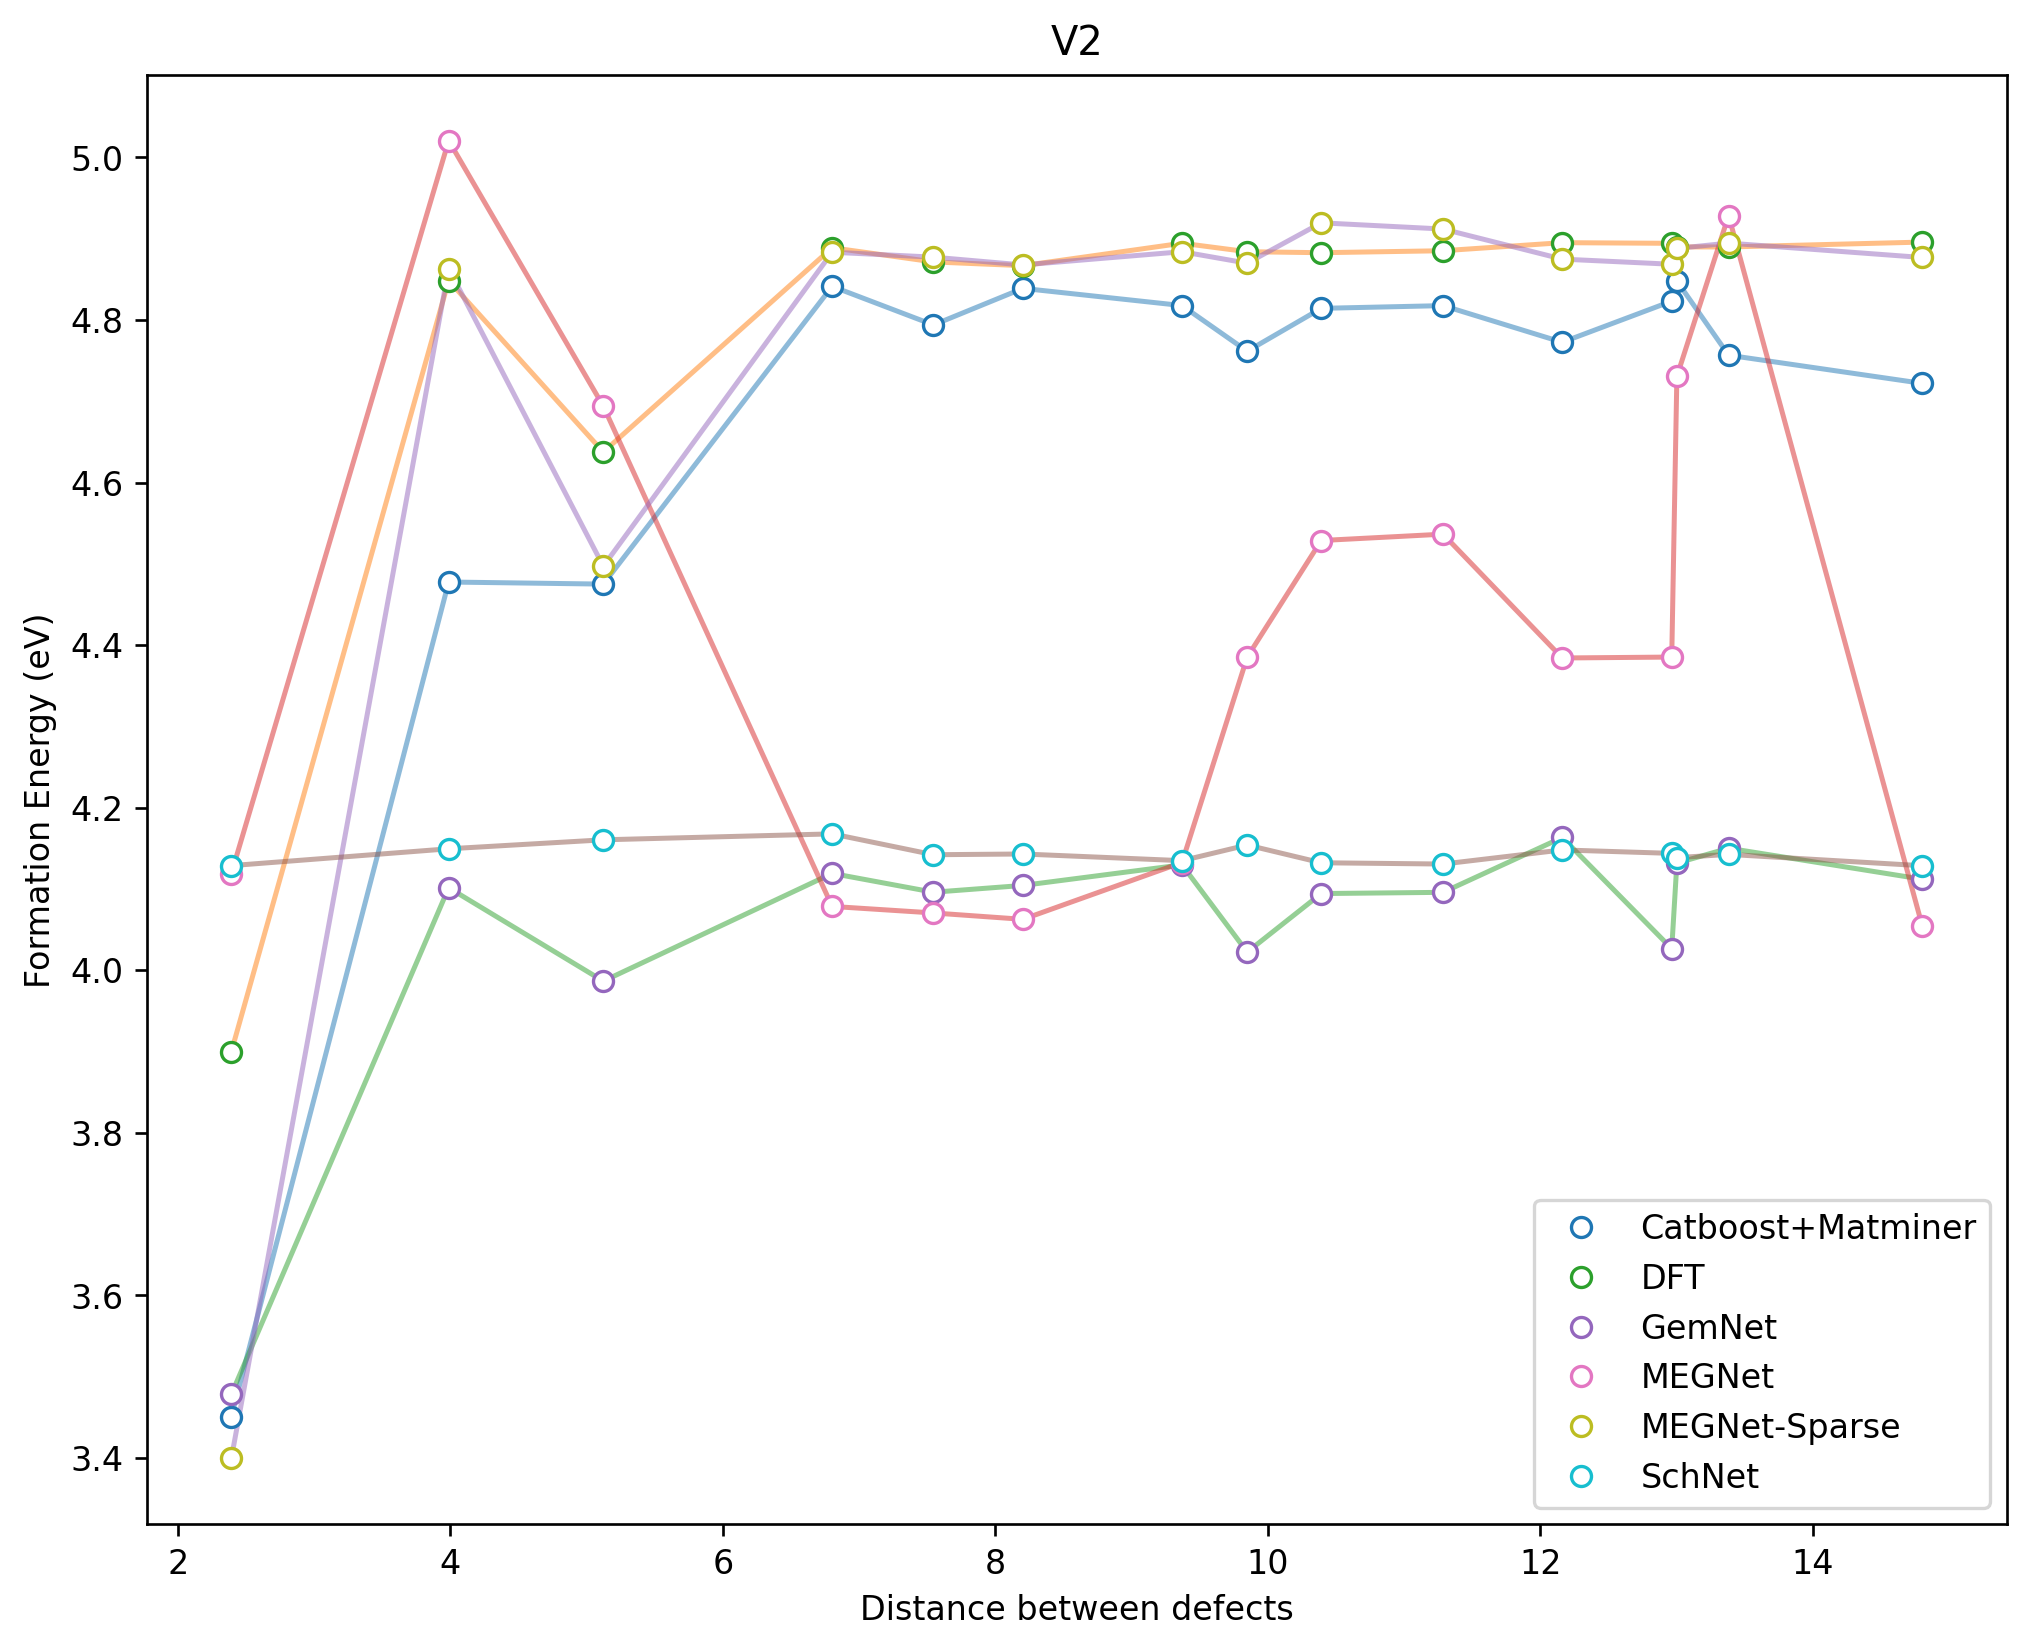

In [33]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v2.index].droplevel(1).assign(v2=v2)

    plot(
        pred.v2,
        pred.formation_energy_per_site,
        legend=legend,
        color=next(colors),
        ax=ax,

        
    )

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Distance between defects')
ax.set_title('V2')

Text(0.5, 1.0, 'V3')

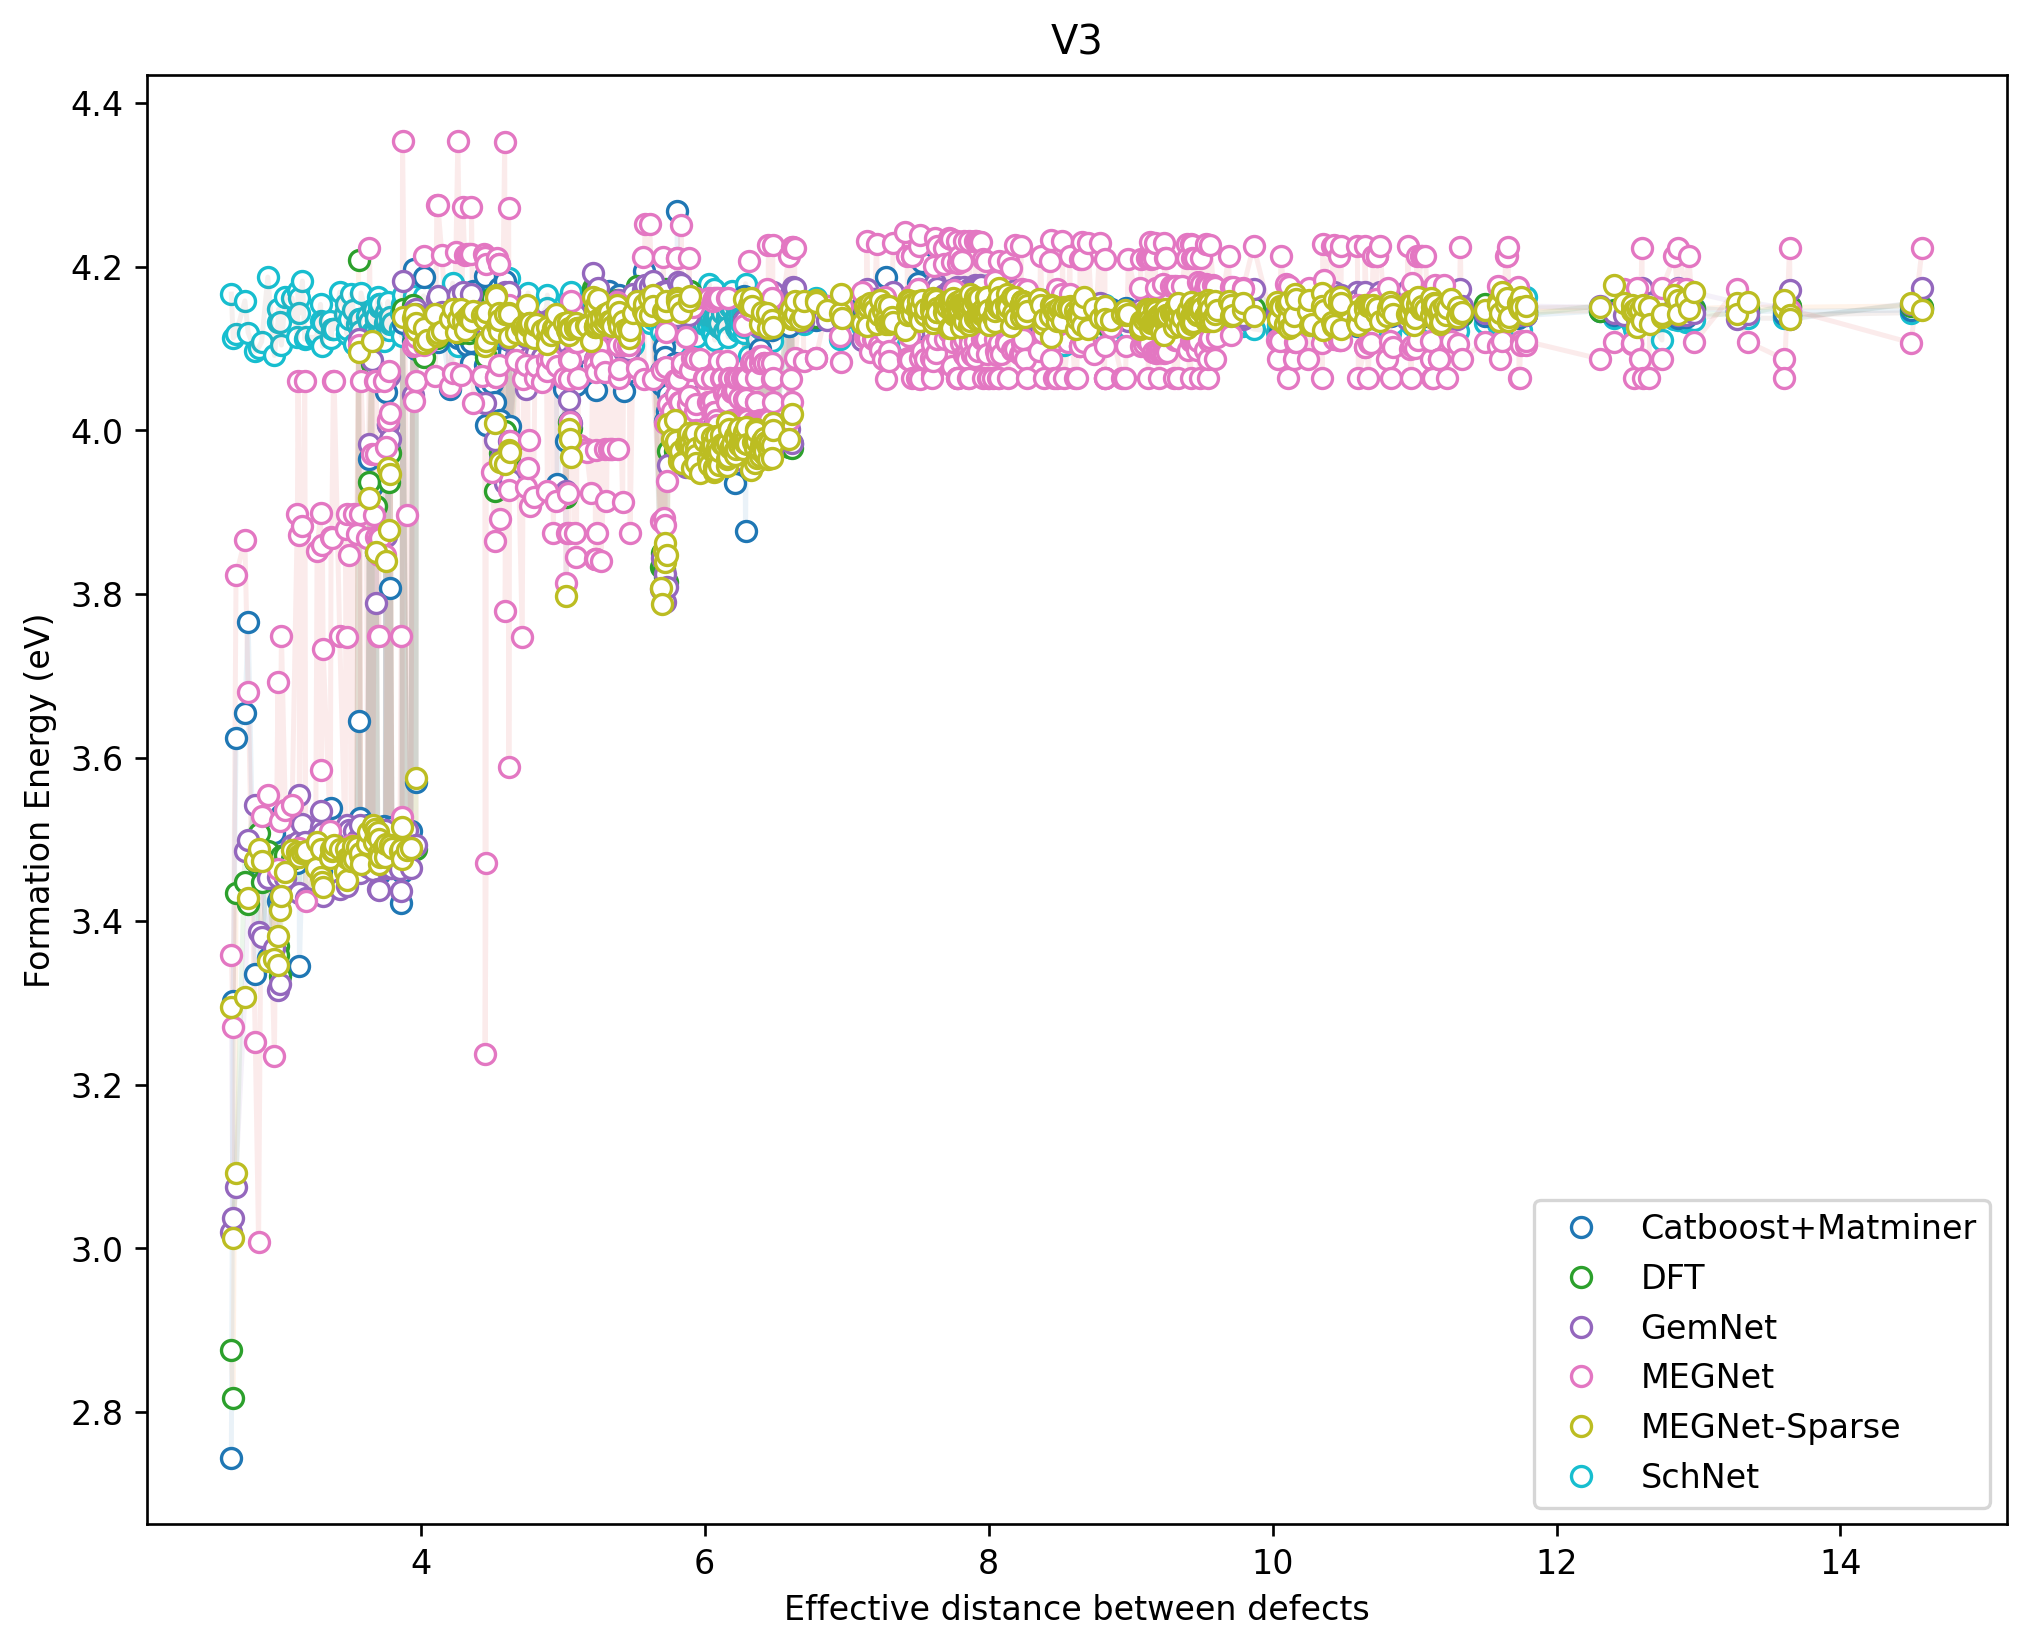

In [32]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v3.index].droplevel(1).assign(v3=v3)

    plot(
        pred.v3,
        pred.formation_energy_per_site,
        legend=legend,
        ax=ax,
        color=next(colors),
        alpha=0.09,
        zorder=-1 if 'SchNet' in legend else 1
    )

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Effective distance between defects')
ax.set_title('V3')